Populating the interactive namespace from numpy and matplotlib
Could not find windows/GM12878_BCLAF1_ENCFF671NSO_ENCFF222GJV+chipulate-1kb.peak.numcopies1.counts
Could not find windows/GM12878_BCLAF1_ENCFF671NSO_ENCFF222GJV+chipulate-1kb.peak.numcopies5.counts
(0.4189989760353197, 5.89063833583093e-151)
(3550,)
(0.24500100801631952, 1.1060416955362036e-49)
(3550,)
(0.34477789484408267, 1.2241757461461813e-99)
(3550,)
Could not find windows/GM12878_H3K27ac_ENCFF097SQI_ENCFF465WTH+chipulate-1kb.peak.numcopies1.counts
Could not find windows/GM12878_H3K27ac_ENCFF097SQI_ENCFF465WTH+chipulate-1kb.peak.numcopies5.counts
(0.45781558815939527, 1.0424121054577793e-144)
(2792,)
(0.7385360129081066, 0.0)
(2792,)
(0.8701297532669974, 0.0)
(2792,)
Could not find windows/GM12878_H3K4me1_ENCFF252ZII_ENCFF966LMJ+chipulate-1kb.peak.numcopies1.counts
Could not find windows/GM12878_H3K4me1_ENCFF252ZII_ENCFF966LMJ+chipulate-1kb.peak.numcopies5.counts
(0.48186373279009764, 6.151233644054043e-158)
(2716,)
(0

/storage/resources/source/anaconda2/envs/py37/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Could not find windows/K562_H3K4me3_ENCFF681JQI_ENCFF127XXD+chipulate-1kb.peak.numcopies1.counts
Could not find windows/K562_H3K4me3_ENCFF681JQI_ENCFF127XXD+chipulate-1kb.peak.numcopies5.counts
(0.3086710833256603, 3.5606250708328603e-35)
(1532,)
(0.6886500726630419, 7.487922670169478e-216)
(1532,)
(0.7564383711447341, 2.140446539997142e-284)
(1532,)
Could not find windows/GM12878_IKZF1_ENCFF216YZE_ENCFF795PEX+chipulate-1kb.peak.numcopies1.counts
Could not find windows/GM12878_IKZF1_ENCFF216YZE_ENCFF795PEX+chipulate-1kb.peak.numcopies5.counts
(0.5114308415537717, 0.0)
(6104,)
(0.3404495914140112, 1.7516848585013705e-165)
(6104,)
(0.7758483825770034, 0.0)
(6104,)
Could not find windows/K562_NFYA_ENCFF000YUR_ENCFF003WYE+chipulate-1kb.peak.numcopies1.counts
Could not find windows/K562_NFYA_ENCFF000YUR_ENCFF003WYE+chipulate-1kb.peak.numcopies5.counts
(0.607313535263903, 4.26737874143529e-167)
(1652,)
(0.2885958654378408, 4.7023829778386815e-33)
(1652,)
(0.44850400563023013, 1.4843286452976

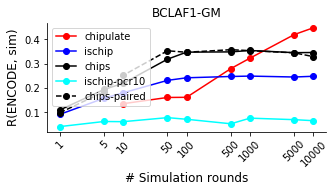

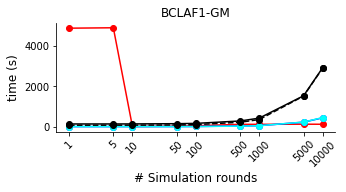

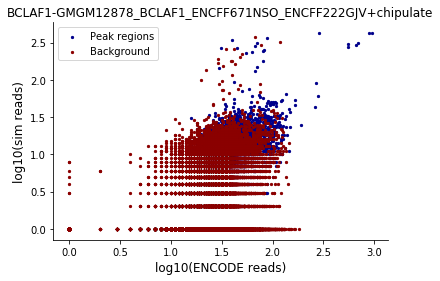

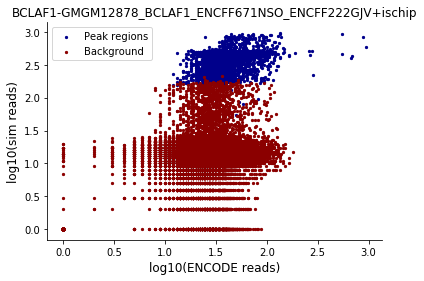

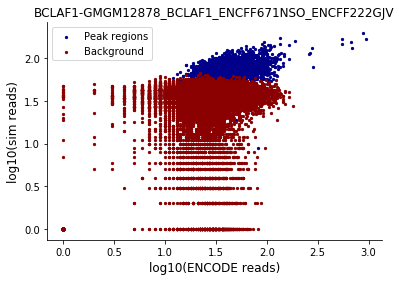

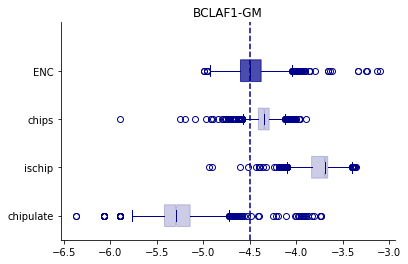

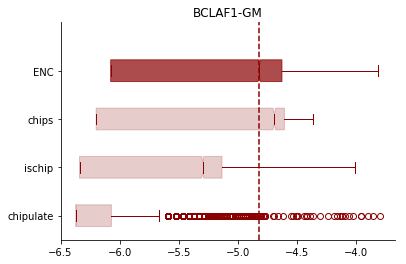

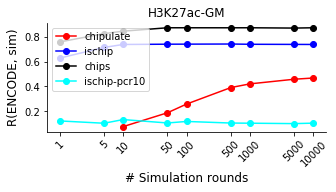

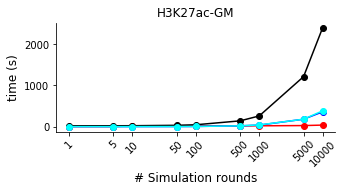

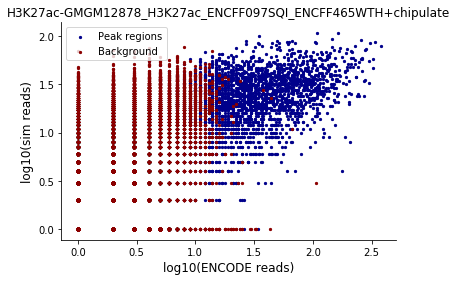

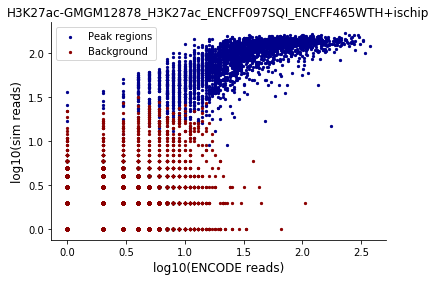

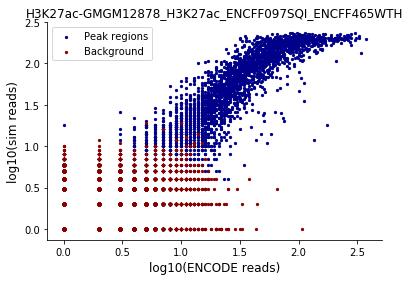

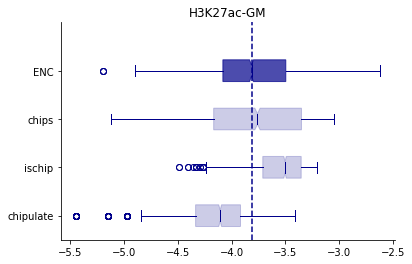

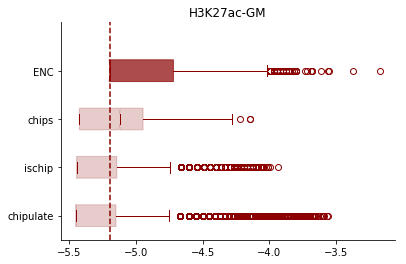

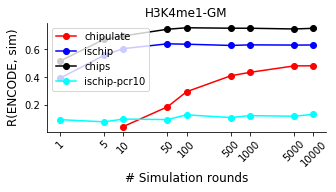

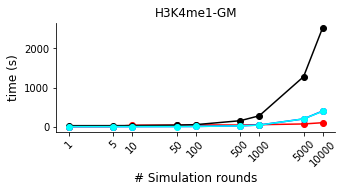

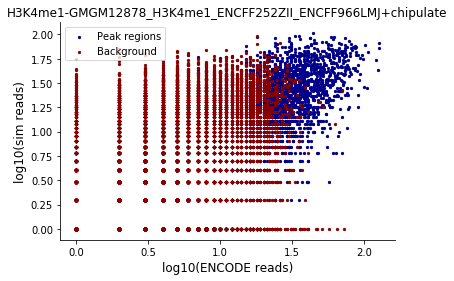

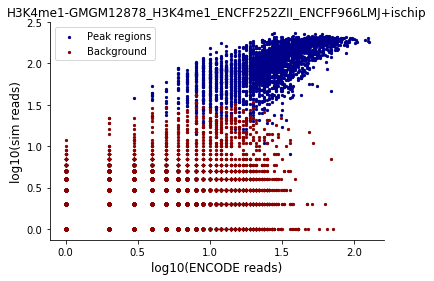

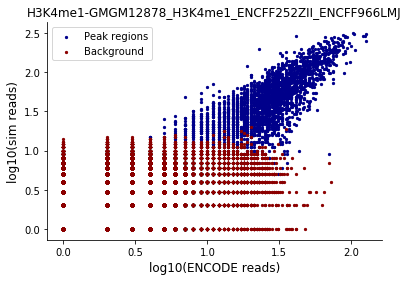

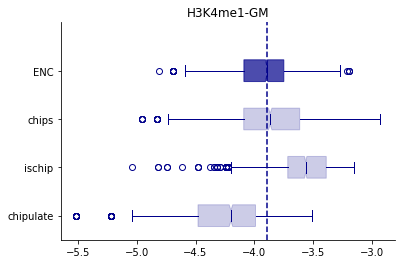

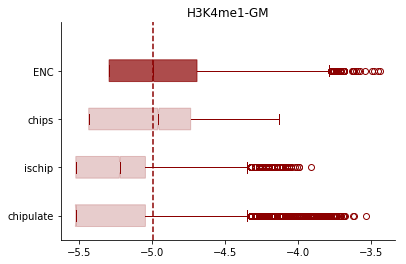

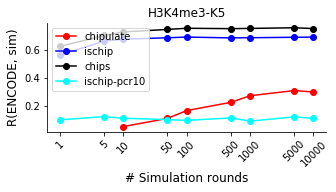

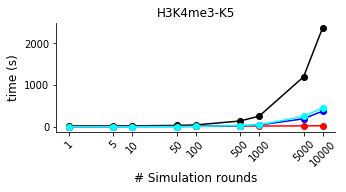

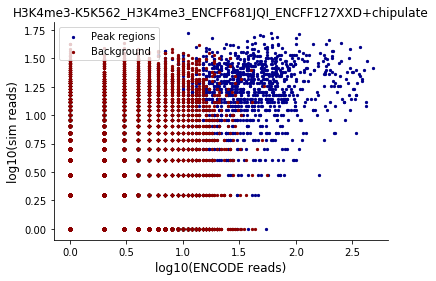

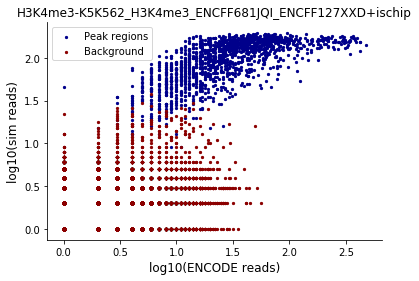

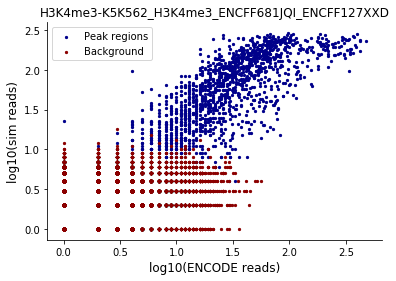

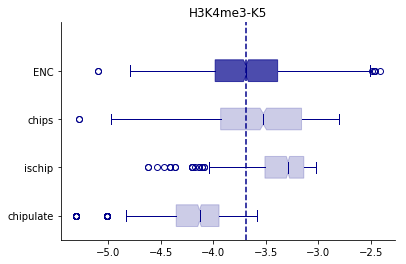

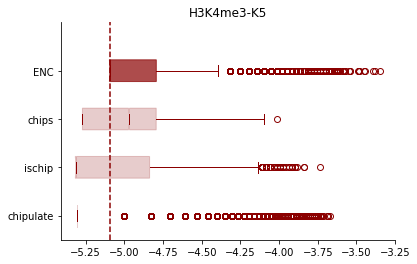

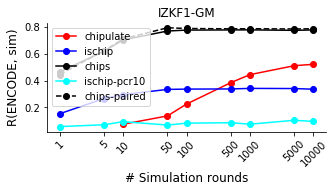

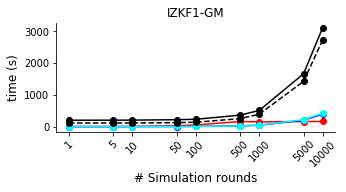

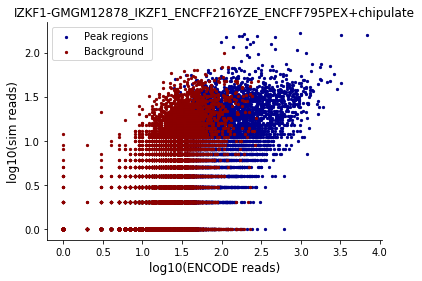

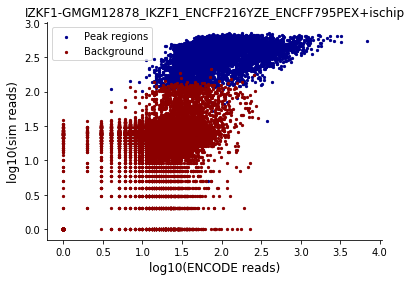

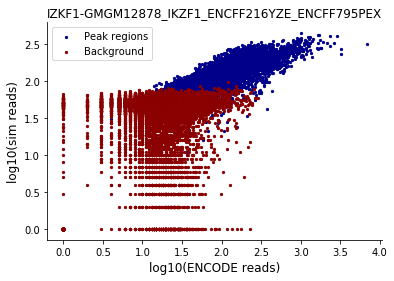

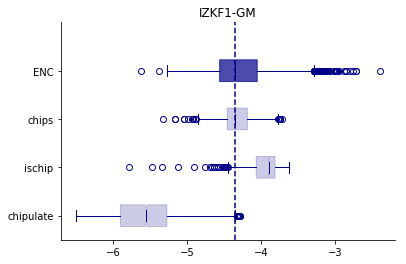

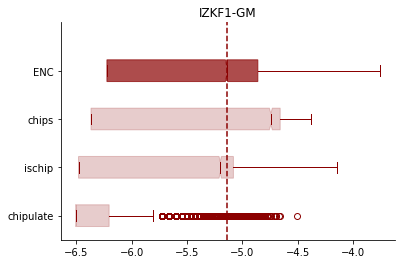

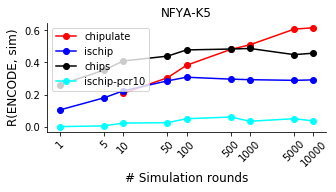

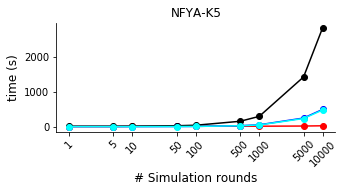

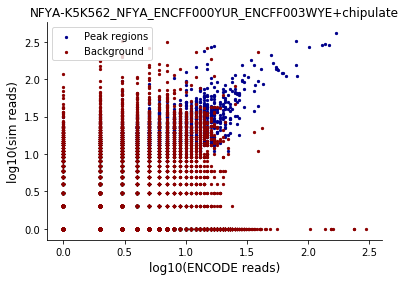

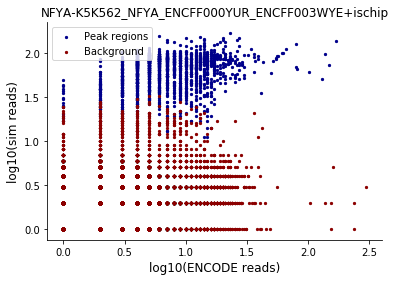

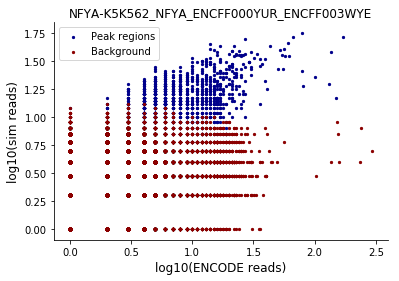

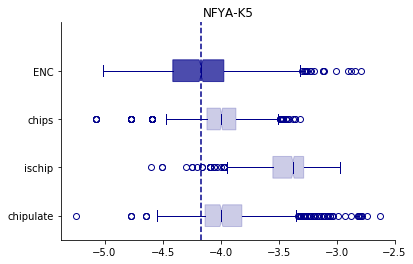

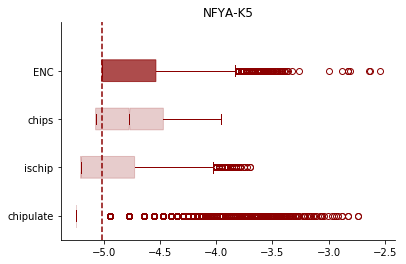

In [44]:
%pylab inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import pandas as pd
import numpy as np
import scipy.stats
import subprocess

SCATTERNUM = 5000
METHODS = ["chipulate","ischip","chips","ischip-pcr10"]

NUMCOPIES = np.array([1, 5, 10, 50, 100, 500, 1000, 5000, 10000])

PREFIXES = {"chips": "", "chipulate": "+chipulate", "ischip": "+ischip", "ischip-pcr10": "+ischip-pcr10"}
COLORS = {"chips": "black", "chipulate": "red", "ischip": "blue","ischip-pcr10": "cyan"}

HMWINDOW = 1
TFWINDOW = 1

DATASETS = {
    "BCLAF1-GM": {
        "OUTPREFIX": "GM12878_BCLAF1_ENCFF671NSO_ENCFF222GJV",
        "WINDOWSIZE": TFWINDOW,
        "paired": True
    },
    "H3K27ac-GM": {
        "OUTPREFIX": "GM12878_H3K27ac_ENCFF097SQI_ENCFF465WTH",
        "WINDOWSIZE": HMWINDOW,
        "paired": False
    },
    "H3K4me1-GM": {
        "OUTPREFIX": "GM12878_H3K4me1_ENCFF252ZII_ENCFF966LMJ",
        "WINDOWSIZE": HMWINDOW,
        "paired": False
    },
    "H3K4me3-K5": {
        "OUTPREFIX": "K562_H3K4me3_ENCFF681JQI_ENCFF127XXD",
        "WINDOWSIZE": HMWINDOW,
        "paired": False
    },
    "IZKF1-GM": {
        "OUTPREFIX": "GM12878_IKZF1_ENCFF216YZE_ENCFF795PEX",
        "WINDOWSIZE": TFWINDOW,
        "paired": True
    },
    "NFYA-K5": {
        "OUTPREFIX": "K562_NFYA_ENCFF000YUR_ENCFF003WYE",
        "WINDOWSIZE": TFWINDOW,
        "paired": False
    }
}

def PlotBoxes(boxdata, encdata, color, title, xlabels, fname=None, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)    
        ax.set_title(title)
    boxdict = ax.boxplot(boxdata+[encdata], positions=range(0, len(peakdata)), notch=True, patch_artist=True,
        boxprops=dict(facecolor=color, color=color),
        capprops=dict(color=color),
        whiskerprops=dict(color=color),
        flierprops=dict(color=color, markeredgecolor=color),
        medianprops=dict(color=color), vert=False)
    ax.axvline(x=np.median(encdata), color=color, linestyle="dashed")

    counter = 0
    for b in boxdict["boxes"]:
        if counter >= len(boxdata):
            b.set_alpha(0.7)
        else:
            b.set_alpha(0.2)
        b.set_edgecolor(color)
        counter += 1

    ax.set_ylim(bottom=-0.5, top=len(peakdata))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_yticks([item for item in range(len(peakdata))])
    ax.set_yticklabels(xlabels)
    if fname is not None and ax is None:
        fig.savefig(fname)

def GetNumReads(OUTPREFIX, method, nc):
    if method == "encode":
        bamfile = "/storage/mgymrek/chipmunk_round2/encode/%s/%s.flagged.bam"%(OUTPREFIX, OUTPREFIX)
    else:
        modifier = PREFIXES[method]
        bamfile = "bams/%s-numcopies%s.flagged.bam"%(OUTPREFIX+modifier, nc)
    cmd = "samtools view %s chr22 | wc -l"%bamfile
    result = subprocess.run(cmd, stdout=subprocess.PIPE, shell=True)
    numreads = int(result.stdout)
    return numreads

def TransformCounts(countdata, numreads):
    # return np.log10((countdata+1)/numreads)
    return coundata/numreads

for ds in DATASETS.keys():
    OUTPREFIX=DATASETS[ds]["OUTPREFIX"]
    WINDOWSIZE=DATASETS[ds]["WINDOWSIZE"]

    # Load Encode data for comparison
    peak = pd.read_csv("windows/%s-%skb.peak.encode.counts"%(OUTPREFIX, WINDOWSIZE),
                             sep="\t",
                             names=["chrom","start","end","encode"])
    nopeak = pd.read_csv("windows/%s-%skb.nopeak.encode.counts"%(OUTPREFIX, WINDOWSIZE),
                             sep="\t",
                             names=["chrom","start","end","encode"])

    # Get numcopies vs. r2, numcopies vs. time. one for each method
    corrs = {}
    times = {}
    for method in METHODS:
        corrs_ = []
        times_ = []
        modifier = PREFIXES[method]
        for nc in NUMCOPIES:
            try:
                dfp = pd.read_csv("windows/%s-%skb.peak.numcopies%s.counts"%(OUTPREFIX+modifier, WINDOWSIZE, nc), sep="\t", names=["chrom","start","end",nc])
                dfnp = pd.read_csv("windows/%s-%skb.nopeak.numcopies%s.counts"%(OUTPREFIX+modifier, WINDOWSIZE, nc), sep="\t", names=["chrom","start","end",nc])
                peak["%s_%s"%(method,nc)] = dfp[nc]
                nopeak["%s_%s"%(method,nc)] = dfnp[nc]
                corrs_.append(scipy.stats.pearsonr(np.log10(peak["encode"]+1), np.log10(peak["%s_%s"%(method,nc)]+1))[0])
            except:
                corrs_.append(None)
                print("Could not find windows/%s-%skb.peak.numcopies%s.counts"%(OUTPREFIX+modifier, WINDOWSIZE, nc))
            try:
                metrics = pd.read_csv("metrics/%s-numcopies%s.sim_metrics"%(OUTPREFIX+modifier, nc), sep="\t")
                times_.append(metrics["s"])
            except:
                times_.append(None)
        corrs[method] = corrs_
        times[method] = times_
    # If paired, add that
    if DATASETS[ds]["paired"]:
        corrs_ = []
        times_ = []
        modifier = "_paired"
        for nc in NUMCOPIES:
            try:
                dfp = pd.read_csv("windows/%s-%skb.peak.numcopies%s.counts"%(OUTPREFIX+modifier, WINDOWSIZE, nc), sep="\t", names=["chrom","start","end",nc])
                dfnp = pd.read_csv("windows/%s-%skb.nopeak.numcopies%s.counts"%(OUTPREFIX+modifier, WINDOWSIZE, nc), sep="\t", names=["chrom","start","end",nc])
                peak["%s_%s"%(method,nc)] = dfp[nc]
                nopeak["%s_%s"%(method,nc)] = dfnp[nc]
                corrs_.append(scipy.stats.pearsonr(np.log10(peak["encode"]+1), np.log10(peak["%s_%s"%(method,nc)]+1))[0])
            except:
                corrs_.append(None)
            try:
                metrics = pd.read_csv("metrics/%s-numcopies%s.sim_metrics"%(OUTPREFIX+modifier, nc), sep="\t")
                times_.append(metrics["s"])
            except:
                times_.append(None)
        corrs[method+modifier] = corrs_
        times[method+modifier] = times_        
        
    # Plot numcopies vs. pearson R. One line per method
    fig = plt.figure()
    fig.set_size_inches((5, 2))
    ax = fig.add_subplot(111)
    for method in METHODS:
        ax.plot(np.log10(NUMCOPIES), corrs[method], color=COLORS[method], marker="o", label=method)
    if DATASETS[ds]["paired"]:
        ax.plot(np.log10(NUMCOPIES), corrs[method+"_paired"], color=COLORS["chips"], 
                linestyle="dashed", marker="o", label="chips-paired")
    ax.set_xticks(np.log10(NUMCOPIES))
    ax.set_xticklabels(NUMCOPIES, rotation=45)
    ax.set_xlabel("# Simulation rounds", size=12)
    ax.set_ylabel("R(ENCODE, sim)", size=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(ds)
    ax.legend(loc="upper left")
    fig.savefig(OUTPREFIX+"-numcopies.pdf")

    # Numcopies vs. time
    fig = plt.figure()
    fig.set_size_inches((5, 2))
    ax = fig.add_subplot(111)
    for method in METHODS:
        #print(list(times[method]))
        ax.plot(np.log10(NUMCOPIES), times[method], COLORS[method], marker="o")
    if DATASETS[ds]["paired"]:
        ax.plot(np.log10(NUMCOPIES), times[method+"_paired"], color=COLORS["chips"], linestyle="dashed", marker="o")
    ax.set_xticks(np.log10(NUMCOPIES))
    ax.set_xticklabels(NUMCOPIES, rotation=45)
    ax.set_xlabel("# Simulation rounds", size=12)
    ax.set_ylabel("time (s)", size=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(ds)
    fig.savefig(OUTPREFIX+"-time.pdf")

    for method in METHODS:
        if "pcr" in method: continue
        if "%s_%s"%(method,SCATTERNUM) not in peak.columns: continue
        
        # Get scatter plot of counts
        modifier = PREFIXES[method]
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(np.log10(peak["encode"]+1), np.log10(peak["%s_%s"%(method,SCATTERNUM)]+1), color="darkblue", s=5, label="Peak regions")
        ax.scatter(np.log10(nopeak["encode"]+1), np.log10(nopeak["%s_%s"%(method,SCATTERNUM)]+1), color="darkred", s=5, label="Background")
        print(scipy.stats.pearsonr(np.log10(peak["encode"]+1), np.log10(peak["%s_%s"%(method,SCATTERNUM)]+1)))
        print(peak["%s_%s"%(method,SCATTERNUM)].shape)
        #ax.set_xlim(left=-0.1, right=xmax)
        #ax.set_ylim(bottom=-0.1, top=ymax)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xlabel("log10(ENCODE reads)", size=12)
        ax.set_ylabel("log10(sim reads)", size=12);
        ax.legend(loc="upper left");
        ax.set_title(ds+OUTPREFIX+modifier)
        fig.savefig(OUTPREFIX+modifier+"-scatter.pdf")
    
    # Get box plots of read counts in/out of peaks
    # Normalize by num. reads mapped to chr22
    
    # First load data
    peakdata = []
    nopeakdata = []
    xlabels = []
    for method in METHODS:
        if "pcr" in method: continue
        if "%s_%s"%(method,SCATTERNUM) not in peak.columns:
            peakdata.append([])
            nopeakdata.append([])
        else:
            numreads = GetNumReads(OUTPREFIX, method, nc)
            peakdata.append(TransformCounts(peak["%s_%s"%(method,SCATTERNUM)], numreads))
            nopeakdata.append(TransformCounts(nopeak["%s_%s"%(method,SCATTERNUM)], numreads))
#            peakdata.append(np.log10((peak["%s_%s"%(method,SCATTERNUM)]+1)/numreads))
#            nopeakdata.append(np.log10((nopeak["%s_%s"%(method,SCATTERNUM)]+1)/numreads))
        xlabels.append(method)
    numencreads = GetNumReads(OUTPREFIX, "encode", None)
#    peakdata.append(np.log10((peak["encode"]+1)/numencreads))
#    nopeakdata.append(np.log10((nopeak["encode"]+1)/numencreads))
    peakdata.append(TransformCounts(peak["encode"], numencreads))
    nopeakdata.append(TransformCounts(nopeak["encode"], numencreads))
    xlabels.append("ENC")

    PlotBoxes(peakdata[:-1], peakdata[-1], "darkblue", ds, xlabels)
    PlotBoxes(nopeakdata[:-1], nopeakdata[-1], "darkred", ds, xlabels)